# Customization

In [ ]:
USERNAME = 'joloujo'
TIMEZONE = 'US/Eastern'
UPDATE = False

## Set up pyLast

In [16]:
from dotenv import load_dotenv
import os
import pylast

# Load environment variables from .env file
load_dotenv()
API_KEY = os.getenv('PYLAST_API_KEY')
API_SECRET = os.getenv('PYLAST_API_SECRET')

# Make sure environment variables were successfully loaded
if API_KEY == None or API_SECRET == None:
    if API_KEY == None:
        print('API Key not found')
    if API_SECRET == None:
        print('API Secret not found')
    print('Exiting')
else:
    network = pylast.LastFMNetwork(API_KEY, API_SECRET)
    network.enable_rate_limit()
    print('Successfully set up pyLast')


Successfully set up pyLast


## Load tracks

In [ ]:
from datetime import datetime
import numpy as np
from pathlib import Path
import pandas as pd
from pylast import PlayedTrack
import pytz
import time

def track_to_df_entry(track: PlayedTrack):
    return {
        'name': track.track.get_name(),
        'artist': track.track.artist.name if track.track.artist else None, 
        'album': track.album, 
        'timestamp': pd.Timestamp(int(track.timestamp), unit='s') if track.timestamp else None, 
        'duration': np.nan,
    }

tracks_path = Path("..") / "data" / "tracks.pkl"
columns = ['name', 'artist', 'album', 'timestamp', 'duration']

tracks: pd.DataFrame

timezone = pytz.timezone(TIMEZONE)

if os.path.exists(tracks_path):
    tracks = pd.read_pickle(tracks_path)
    print('Loaded tracks from file')
else:
    tracks = pd.DataFrame(columns=columns)

user = network.get_user(USERNAME)

if UPDATE:
    time_to = round(time.time())
    time_from: int = int(tracks['timestamp'].max().timestamp()) + 1 if tracks['timestamp'].size > 0 else 0

    print(f'Loading songs starting from {datetime.fromtimestamp(time_from, timezone).strftime("%m/%d/%Y %H:%M:%S %Z")}')

    while True:
        new_tracks = list(user.get_recent_tracks(limit=500, time_to=time_to, time_from=time_from))

        if len(new_tracks) == 0:
            print('Done fetching tracks')
            break

        print(f'fetched tracks {len(tracks) + 1} to {len(tracks) + len(new_tracks)}')

        last_timestamp = new_tracks[-1].timestamp

        new_tracks_df = pd.DataFrame([track_to_df_entry(track) for track in new_tracks])

        tracks = pd.concat([tracks, new_tracks_df], ignore_index=True)

        if last_timestamp == None: 
            print('Song with no timestamp encountered')
            break

        time_to = int(last_timestamp)

    tracks.to_pickle(tracks_path)
    print('Saved tracks to file')

print(f'Loaded songs up to {tracks['timestamp'].max().tz_localize(TIMEZONE).strftime("%m/%d/%Y %H:%M:%S %Z")}')



Loaded tracks from file
Loading songs starting from 11/05/2025 21:06:27 EST
fetched tracks 6035 to 6035
Done fetching tracks
Saved tracks to file
Loaded songs up to 11/06/2025 02:09:41 EST


## Get track durations

In [18]:
print(f'There are {tracks['duration'].isnull().sum()} tracks with no duration')

durations: list[int | None] = tracks['duration'].tolist()
print(durations)

last_save = time.time()
save_period = 1

for i, row in enumerate(tracks.itertuples()):
    if not pd.isnull(row.duration):
        continue

    artist = str(row.artist)
    name = str(row.name)

    track = network.get_track(artist, name) # Takes no time

    try:
        duration = track.get_duration() # The slow API call (about 0.2 seconds)
    except Exception as e:
        print(f'Error on track {i}: {e}')
        duration = 0


    durations[i] = int(duration)

    if time.time() >= last_save + save_period:
        start_time = time.perf_counter()
        tracks['duration'] = durations
        last_save = time.time()
        print(f'Saved up to track {i} in {(time.perf_counter() - start_time) * 1000} ms.')

tracks.to_pickle(tracks_path)


There are 6 tracks with no duration
[215000.0, 95000.0, 236000.0, 311000.0, 164000.0, 197000.0, 0.0, 200000.0, 172000.0, 0.0, 288000.0, 198000.0, 153000.0, 146000.0, 205000.0, 271000.0, 193000.0, 146000.0, 161000.0, 198000.0, 219000.0, 168000.0, 238000.0, 197000.0, 97000.0, 156000.0, 144000.0, 195000.0, 259000.0, 294000.0, 165000.0, 120000.0, 217000.0, 324000.0, 112000.0, 0.0, 0.0, 325000.0, 214000.0, 224000.0, 280000.0, 129000.0, 0.0, 248000.0, 185000.0, 0.0, 186000.0, 144000.0, 203000.0, 244000.0, 0.0, 131000.0, 324000.0, 302000.0, 213000.0, 208000.0, 156000.0, 209000.0, 209000.0, 96000.0, 180000.0, 0.0, 167000.0, 196000.0, 0.0, 112000.0, 160000.0, 206000.0, 160000.0, 206000.0, 199000.0, 0.0, 234000.0, 231000.0, 168000.0, 302000.0, 188000.0, 256000.0, 205000.0, 0.0, 133000.0, 0.0, 143000.0, 0.0, 88000.0, 214000.0, 230000.0, 182000.0, 0.0, 136000.0, 125000.0, 115000.0, 102000.0, 148000.0, 139000.0, 125000.0, 180000.0, 198000.0, 0.0, 302000.0, 99000.0, 240000.0, 196000.0, 0.0, 286000.0

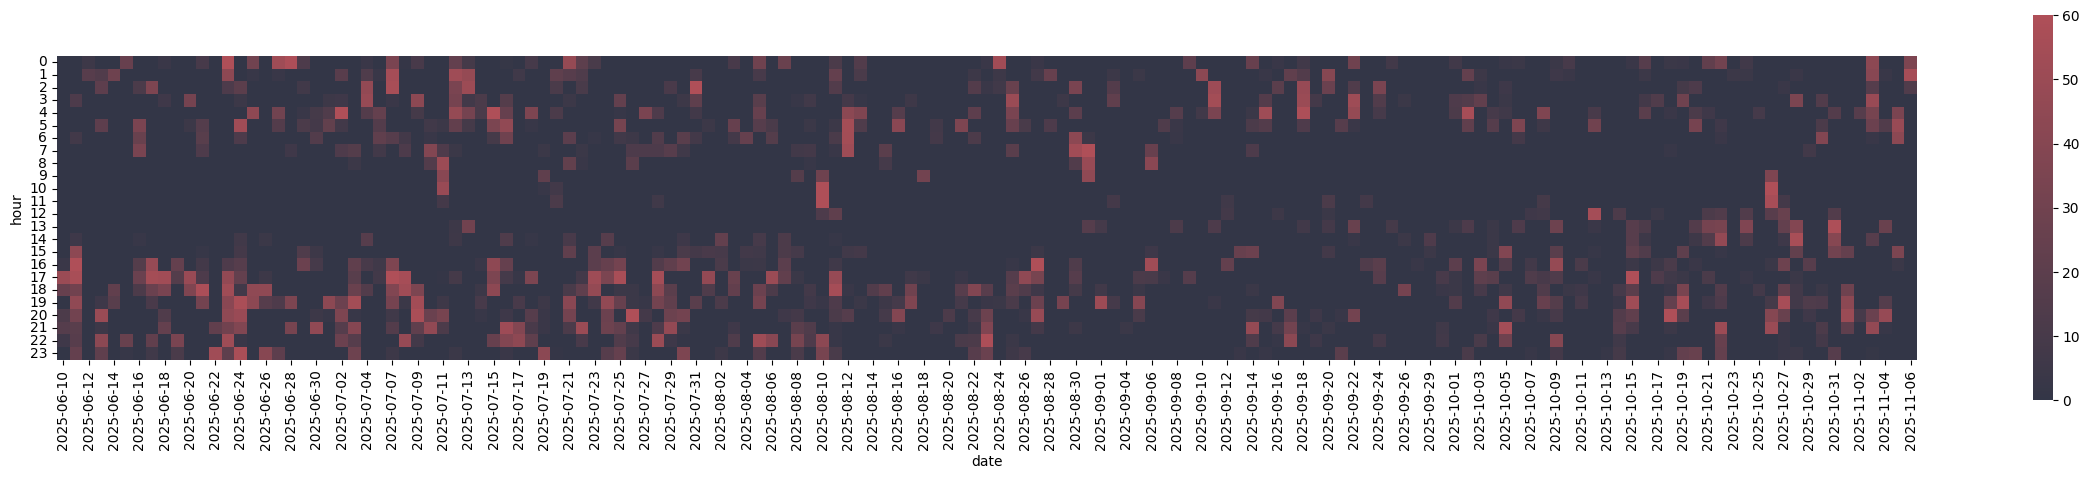

In [87]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

heatmap_data = pd.DataFrame()
heatmap_data['date'] = tracks['timestamp'].dt.date
heatmap_data['hour'] = tracks['timestamp'].dt.hour
heatmap_data['duration'] = tracks['duration']

grouped_heatmap_data = heatmap_data.groupby(['date', 'hour'], as_index=False).sum()
grouped_heatmap_data['duration'] = grouped_heatmap_data['duration'].div(60 * 1000)

heatmap = grouped_heatmap_data.pivot(index='hour', columns='date', values='duration').fillna(0)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(51, 175, N)/255
vals[:, 1] = np.linspace(54, 79, N)/255
vals[:, 2] = np.linspace(71, 88, N)/255
newcmp = ListedColormap(vals)

fig = plt.figure(figsize=(30, 5)) 
plot = sns.heatmap(heatmap, vmin=0, vmax=60, square=True, cmap=newcmp)
fig.savefig("heatmap.png") # type: ignore